https://colab.research.google.com/github/JunetaeKim/GCSP-HBDA/blob/main/Week7/GrdientTape_l1l2.ipynb

# TensorFlow DNN Tutorial - Jupyter Notebook Version

## **Introduction to Deep Learning with TensorFlow**

This provides a tutorial on implementing deep neural networks (DNN) using TensorFlow. 
It focuses on applying L1 and L2 regularization manually using tf.GradientTape for better control and understanding.

Deep learning models tend to overfit, meaning they memorize the training data rather than generalizing well to unseen data. 
Regularization techniques such as L1 (Lasso) and L2 (Ridge) help improve generalization by constraining the model's parameters.
In this tutorial, we will explore how to manually apply these techniques using TensorFlow's GradientTape.

## **1. Setting Up TensorFlow**

In [3]:
#!pip install tensorflow numpy matplotlib scikit-learn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
print(tf.__version__)

2.10.0


## **2. Creating a Toy Dataset**
#### A synthetic dataset is useful for understanding how L1 and L2 regularization impact model training. 
#### We generate random feature vectors and corresponding labels.

In [5]:
# Generate sample data
X = np.random.rand(1000, 10)
y = np.random.randint(0, 2, size=(1000,))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **3. Implementing L1 & L2 Regularization with GradientTape**

### **Define Custom Regularization Function**

#### L1 regularization penalizes the absolute values of the weights, leading to sparsity in the model (some weights become zero). 
#### L2 regularization penalizes the squared values of the weights, which helps prevent large weight values and improves stability.

In [6]:
def l1_l2_regularization(weights, l1=0.01, l2=0.01):
    return l1 * tf.reduce_sum(tf.abs(weights)) + l2 * tf.reduce_sum(tf.square(weights))

### **Define a Custom Training Step with Regularization**

#### Using tf.GradientTape, we compute gradients and manually add L1/L2 regularization loss to the total loss.

In [7]:
def train_step(model, optimizer, loss_fn, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)
        reg_loss = sum(l1_l2_regularization(layer.kernel) for layer in model.layers if hasattr(layer, 'kernel'))
        total_loss = loss + reg_loss
    
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

## **4. Building and Training the Model**

### **Define a Simple DNN**
#### This model consists of three layers, where each layer applies the ReLU activation function to introduce non-linearity.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model before training/testing
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **Compile Model and Train Using Custom Training Loop**

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

for epoch in range(10):
    loss = train_step(model, optimizer, loss_fn, X_train, y_train)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

Epoch 1, Loss: 13.0782
Epoch 2, Loss: 12.9292
Epoch 3, Loss: 12.7818
Epoch 4, Loss: 12.6356
Epoch 5, Loss: 12.4909
Epoch 6, Loss: 12.3476
Epoch 7, Loss: 12.2055
Epoch 8, Loss: 12.0648
Epoch 9, Loss: 11.9256
Epoch 10, Loss: 11.7874


## **5. Understanding the Impact of L1 & L2 Regularization**

### **Display Regularized Weights**
#### Regularization affects the weight distribution, pushing unnecessary weights toward zero and reducing complexity.

In [14]:
for layer in model.layers:
    if hasattr(layer, 'kernel'):
        print(f'Layer: {layer.name}, Regularized Weights: {layer.kernel.numpy()}')

Layer: dense_3, Regularized Weights: [[-0.10528363 -0.07025541 -0.02767022 ... -0.01465642 -0.09236439
  -0.02959546]
 [ 0.04060793 -0.15967962  0.155569   ... -0.02949466  0.07974542
   0.12811108]
 [-0.02316    -0.00017011 -0.0349676  ... -0.10548448  0.03252522
  -0.14209041]
 ...
 [-0.0494744  -0.09723233 -0.1195354  ...  0.0964068  -0.1267807
   0.01476271]
 [ 0.12154808  0.0596876  -0.03958571 ...  0.16512296  0.13419013
  -0.1422494 ]
 [-0.01680803 -0.04002903 -0.02767006 ...  0.04656839 -0.12917888
   0.07815712]]
Layer: dense_4, Regularized Weights: [[-9.31106284e-02 -1.31267503e-01 -9.99342129e-02 ... -1.77748955e-03
   1.55297607e-01  1.40790194e-01]
 [-8.76100659e-02 -1.30103334e-04 -2.19084136e-02 ... -1.29603535e-01
   8.34237337e-02  1.04655018e-02]
 [ 1.44727007e-01 -1.04990594e-01  4.90552820e-02 ...  1.80220492e-02
  -1.47314340e-01 -2.52827648e-02]
 ...
 [ 1.48240671e-01  9.24005881e-02 -1.48745582e-01 ... -1.24787152e-01
   8.62960815e-02  1.10022552e-01]
 [-5.84540

### **Compare Model Performance**
#### We evaluate the model on the test set to understand how well it generalizes.

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

7/7 [==============================] - 0s 2ms/step - loss: 1.9156 - accuracy: 0.5800
Test Loss: 1.915555477142334, Test Accuracy: 0.5799999833106995


## **6. Visualizing Regularization Effects**

### **Plot Weight Distribution**
#### A well-regularized model has weights that are neither too large nor too small.
#### The following histogram visualizes weight distribution.

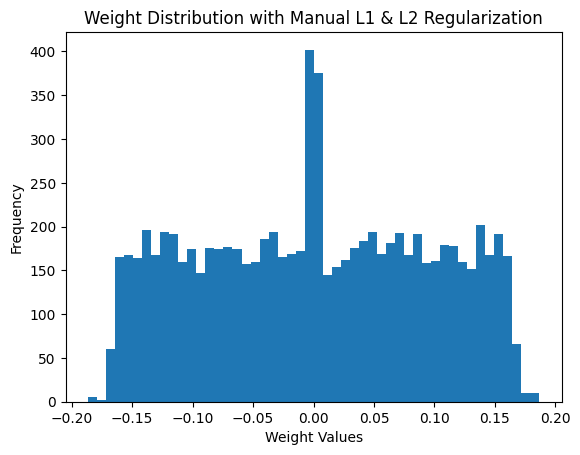

In [16]:
weights = model.layers[1].get_weights()[0].flatten()
plt.hist(weights, bins=50)
plt.title('Weight Distribution with Manual L1 & L2 Regularization')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.show()

## **7. Key Takeaways and Best Practices**

#### **L1 Regularization**: Encourages sparsity, useful for feature selection.

#### **L2 Regularization**: Prevents large weights, leading to more stable models.

#### **Manual Implementation using GradientTape**: Provides better control over the loss function.
